# HW4P1: Language Modelling

Welcome to the final part 1 hw of this course. This is the only part 1 in which you have PyTorch training (Yay). You will be working on training language models and evaluating them on the task of prediction and generation.<br>
Note: A major change which we have made this semester is that we have made the model which you will be coding in this HW very similar to the Speller module from HW4P2. 

# Get modules and datasets

In [1]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# TODO: Import drive if you are using Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import sys
#sys.path.append("HW4/") # TODO: Add path to handout/
%cd "/content/drive/MyDrive/CMUSpring/11.685/"

/content/drive/MyDrive/CMUSpring/11.685


In [ ]:
#!pip install -r requirements.txt
#!pip install matplotlib
#!pip install tqdm

In [3]:
%matplotlib inline

import torch
from torch.autograd import Variable
import os

import time 
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchsummaryX

# Importing necessary modules from hw4
# from hw4.tests_hw4 import test_prediction, test_generation
from hw4.tests_hw4 import test_prediction, test_generation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)


Device:  cpu


# Load datasets

In [4]:
# Loading the vocabulary. Try printing and see
VOCAB       = np.load('dataset/vocab.npy') # np.load('dataset/vocab.npy') 

# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(VOCAB)

Vocab length:  33280
['!' '"' '#' ... '～' '<sos>' '<eos>']


In [5]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('dataset/wiki.train.npy', allow_pickle=True)
print(dataset[0].shape)
# The dataset does not have <sos> and <eos> because they are just regular articles. 
# TODO: Add <sos> and <eos> to every article in the dataset.
# Before doing do, try printing the dataset to see if they are words or integers.
dataset_soseos = []
total_len = 0
for d in dataset:
    d = np.append(SOS_TOKEN, d)
    d = np.append(d, EOS_TOKEN)
    dataset_soseos.append(d)
    total_len+=len(d)
avg_len = total_len/len(dataset_soseos) # 3587
dataset = np.array(dataset_soseos)
print(dataset[0].shape)

(3803,)
(3805,)


<ipython-input-5-4b3d0bedd49f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset_soseos)


In [6]:
# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('fixtures/prediction_test.npz')   # test

print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)

Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)


In [7]:
# Loading the fixtures for validation and test - generation
fixtures_gen        = np.load('fixtures/generation.npy')        # validation
fixtures_gen_test   = np.load('fixtures/generation_test.npy')   # test

print("Validation Gen Shapes    :", fixtures_gen.shape)
print("Test Gen Shapes          :", fixtures_gen_test.shape)

Validation Gen Shapes    : (32, 21)
Test Gen Shapes          : (128, 31)


In [8]:
# Example Prediction Dev Input and Output
# Optional TODO: You can try printing a few samples from the validation set which has both inputs and outputs
print(fixtures_gen[0])
print(fixtures_gen_test[0])


[33278 32885 31353 22124 32747 20202 28955    76 16786 25881 31453 32846
 32022 14686 31543 15794    79  9916 25821 31365 32846]
[33278  8881 12851 15340  4557  7384    79  1419 30389 15659     1  4428
     1    76 22968 31353   802 31356 27358 25821 31353 10590 11533 26805
  9139  5843    79  7339 32747 26534 15773]


# Custom DataLoader

In [9]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, batch_size, seq_len=10, shuffle= True, drop_last= False): 
        
        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.batch_size = batch_size
        self.seq_len    = seq_len # any fixed length is Okay according to piazza
        self.shuffle    = shuffle
        self.drop_last  = drop_last

    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length
        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed 
        concat_data = np.concatenate(self.dataset)
        conncat_batch_size =  self.batch_size*self.seq_len
        # subtract 1 to handle the case when len(concat_data) could exactly be divided
        num_batches = (len(concat_data)-1) // conncat_batch_size

        
        return num_batches if self.drop_last else num_batches+1

    def __iter__(self):
        # TODOs: 
        # 1. Shuffle data if shuffle is True
        # 2. Concatenate articles and drop extra words
        # 3. Divide the concetenated dataset into inputs and targets. How do they vary? 
        # 4. Reshape the inputs and targets into batches (think about the final shape)
        # 5. Loop though the batches and yield the input and target according to the sequence length

        if self.shuffle:
            self.dataset = np.random.permutation(self.dataset)
        concat_data = np.concatenate(self.dataset)
        x = torch.LongTensor(concat_data[:-1])
        y = torch.LongTensor(concat_data[1:])
        conncat_batch_size = self.batch_size*self.seq_len
        num_batches = len(x) // conncat_batch_size 
 
        batch_idx = 0
        if self.drop_last:
            # drop the last batch if drop_last
            x = x[:num_batches*conncat_batch_size]
            y = y[:num_batches*conncat_batch_size]
            
        # reshape to be batch_idx slice
        x = np.reshape(x, (num_batches, self.batch_size, self.seq_len))
        y = np.reshape(y, (num_batches, self.batch_size, self.seq_len))

        while batch_idx < num_batches:

            x_i = x[batch_idx]
            y_i = y[batch_idx]
            batch_idx += 1
            yield x_i, y_i


In [19]:
# Some sanity checks

dl = DataLoaderForLanguageModeling(
    dataset     = dataset, 
    batch_size  = 32, 
    shuffle     = True, 
    drop_last   = True
    # Input Extra parameters here if needed
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)

for x, y in dl:
    print("x: ", [VOCAB[i] for i in x[0, :]])
    print("y: ", [VOCAB[i] for i in y[0, :]])
    break

torch.Size([32, 10]) torch.Size([32, 10])
x:  ['<sos>', '=', 'Plum', 'cake', '=', '<eol>', 'Plum', 'cake', 'refers', 'to']
y:  ['=', 'Plum', 'cake', '=', '<eol>', 'Plum', 'cake', 'refers', 'to', 'a']


# LanguageModel

In [10]:

class LockedDropout(torch.nn.Module):
    def __init__(self, dropout=0.35):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x)
        return mask * x


In [35]:
# Here comes the main portion of this HW.
# You can do this with a regular LSTM similar to HW3P2. 
# However, using LSTMCells will make this Language model very similar to the decoder in HW4P2 and we recommend you use that for writing resuable code.

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, embed_size=256, hidden_size=256): # TODO: Add more parameters if you want
        super().__init__()

        # For all the layers which you will define, please read the documentation thoroughly before implementation
        self.token_embedding    = torch.nn.Embedding(vocab_size, embed_size) # TODO: Define a PyTorch embedding layer 

        self.lstm_cells         = torch.nn.Sequential(
            torch.nn.LSTMCell(embed_size, hidden_size*2), 
            torch.nn.LSTMCell(hidden_size*2, hidden_size)
            # TODO: Enter the parameters for the LSTMCells
            # You can add multiple LSTMCells too if you want
        )
        self.hidden_size_dim = [hidden_size*2, hidden_size]
        self.lockdropout = LockedDropout()

        self.token_probability  = torch.nn.Linear(hidden_size, vocab_size) # TODO: Define the parameters

        # Optional TODO: Weight Tying. You just need to make the embedding layer weights equal to the Linear layer weight. 
        self.token_embedding.weight = self.token_probability.weight      
        # So the basic pipline is:
        # word -> embedding -> lstm -> projection (linear) to get  probability distribution
        # And this is happening across all time steps

    def rnn_step(self, embedding, hidden_states_list):
        for i in range(len(self.lstm_cells)):
          hidden_states_list[i] = self.lstm_cells[i](embedding, hidden_states_list[i])
          embedding = hidden_states_list[i][0]

        return embedding, hidden_states_list
        """
        new_hidden_list = []
        batch_size = embedding.shape[0]
        for i in range(len(self.lstm_cells)):
            if hidden_states_list[i] is None:
                h0 = torch.zeros(batch_size, self.hidden_size_dim[i]).requires_grad_()
                c0 = torch.zeros(batch_size, self.hidden_size_dim[i]).requires_grad_()
            else:
                h0, c0 = hidden_states_list[i]
            # TODO: Forward pass through each LSTMCell
            hi, ci = self.lstm_cells[i](embedding, (h0, c0))
            embedding = hi
            new_hidden_list.append((hi, ci))
            
        return embedding, new_hidden_list
        """

    def predict(self, x):
        # Refer to Section 1.3.1 to understand this function
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        with torch.inference_mode():
            # TODO: Pass the input sequence through the model 
            token_prob_dist, hidden_states_list  = self.forward(x)
            # and return the probability distribution of the last timestep

            return token_prob_dist[:, -1]

    def generate(self, x, timesteps): 
        # Refer to section 1.3.2 to understand this function
        # Important Note: We do not draw <eos> from the distribution unlike the writeup
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        # TODO: Pass the input sequence through the model 
        # Obtain the probability distribution and hidden_states_list of the last timestep
        
        token_prob_dist, hidden_states_list     = self.forward(x)
        #next_token                              = torch.argmax(token_prob_dist, dim=2)[:,-1].unsqueeze(1)
        next_token                              = torch.unsqueeze(torch.argmax(token_prob_dist[:, -1, :-2], axis=1), axis=1)
        # TODO: Draw the next predicted token from the probability distribution ()  

        generated_sequence  = [] 
        with torch.inference_mode():
            for t in range(timesteps): # Loop through the timesteps
                #   TODO: Pass the next_token and hidden_states_list through the model
                token_prob_dist, hidden_states_list     = self.forward(next_token, hidden_states_list)
                #   TODO: You will get 2 outputs. What is the shape of the probability distribution?
                #   TODO: Get the most probable token for the next timestep
                next_token                              = torch.unsqueeze(torch.argmax(token_prob_dist[:, -1], axis=1), axis=1)     
                generated_sequence.append(torch.squeeze(next_token))
            
            generated_sequence = torch.stack(generated_sequence, dim= 1) # keep last timesteps generated words
            #generated_sequence = torch.cat(generated_sequence, axis= 1)
        return generated_sequence

    # We are also having a hidden_states_list parameter because you need that in generation
    def forward(self, x, hidden_states_list= None): # train model
        # x (Batch, Seq_len)
        # Note: you dont have to return the sum of log probabilities according to Pseudocode 1 in the writeup
        # However, feel free to calculate and print it if you are curious

        batch_size, timesteps   = x.shape 

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps
        # Initializing the hidden states
        hidden_states_list      = [None]*len(self.lstm_cells) if hidden_states_list == None else hidden_states_list       

        token_embeddings        = self.token_embedding(x) # TODO
        token_embeddings        = self.lockdropout(token_embeddings)
        # When you get the embeddings of the input x, remember that you get it for all time steps.
        # Embedding is just a linear transformation so you can precompute it for all time steps.

        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps

            token_embedding_t           = token_embeddings[:, t] # TODO  
            # batch, embed size

            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list) 
            # TODO (What should you do with the hidden_states_list?)
            
            token_prob_dist_t           = self.token_probability(rnn_out) # TODO

            token_prob_distribution.append(token_prob_dist_t) 

        token_prob_distribution = torch.stack(token_prob_distribution, dim=1) # TODO: Stack along the timesteps dimension

        return token_prob_distribution, hidden_states_list 

# Trainer Class

In [24]:
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does. 
scaler = torch.cuda.amp.GradScaler()

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler, max_epochs = 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion

        self.train_losses           = []
        self.val_losses             = []
        self.predictions            = []
        self.predictions_test       = []
        self.generated_logits       = []
        self.generated              = []
        self.generated_logits_test  = []
        self.generated_test         = []
        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words. 
        # Tip: What is the total number of words in this batch? 
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        out     = out.view(-1, out.size(2)) # TODO
        targets = target.flatten() # TODO
        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0
        batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
        for batch_num, (inputs, targets) in enumerate(self.loader):
            self.optimizer.zero_grad()
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            with torch.cuda.amp.autocast(): 
                out, _ = self.model(inputs)
                loss = self.calculate_loss(out, targets)

                # TODO: Complete the loop. You should be able to complete this without any helper comments after 3 HWs
                # Tip: Mixed precision training
                # For loss calculation, use the calculate_loss function. You need to complete it before using.
    
            epoch_loss += loss.item()
            
            batch_bar.set_postfix(
                loss="{:.04f}".format(float(epoch_loss / (batch_num + 1))),
                lr="{:.06f}".format(float(self.optimizer.param_groups[0]['lr'])))
            batch_bar.update()

            if DEVICE == 'cpu':
                loss.backward()
                self.optimizer.step()
            else:
                scaler.scale(loss).backward() # This is a replacement for loss.backward()
                scaler.step(self.optimizer) # This is a replacement for optimizer.step()
                scaler.update() 
            del inputs, targets, out, _, loss
            #torch.cuda.empty_cache()
        batch_bar.close()
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                      % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)


    
    def test(self): # Don't change this function

        self.model.eval() # set to eval mode
        predictions     = model.predict(fixtures_pred['inp']).detach().cpu().numpy() # get predictions
        self.predictions.append(predictions)
        
        generated_logits        = model.generate(fixtures_gen, 10).detach().cpu().numpy() # generated predictions for 10 words
        generated_logits_test   = model.generate(fixtures_gen_test, 10).detach().cpu().numpy()

        nll             = test_prediction(predictions, fixtures_pred['out'])
        generated       = test_generation(fixtures_gen, generated_logits, VOCAB)
        generated_test  = test_generation(fixtures_gen_test, generated_logits_test, VOCAB)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll

    
    def save(self): # Don't change this function

        model_path = os.path.join('hw4/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        
        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])

        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])

/usr/local/lib/python3.9/dist-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


# Experiment setup

In [36]:
# TODO: define other hyperparameters here

configs = dict(
    batch_size  = 512,
    num_epochs  = 20, # 10 or 20 epochs should be enough given the model is good

    init_lr     = 0.002 # TODO
)

In [37]:
model       = LanguageModel(NUM_WORDS+2, 256, 256) # TODO: Define the model

loader      = DataLoaderForLanguageModeling(
    dataset     = dataset, 
    batch_size  = configs['batch_size'], 
    shuffle     = True, 
    drop_last   = True
    # Input Extra parameters here if needed
)
inputs, targets = next(iter(loader))

criterion   = torch.nn.CrossEntropyLoss() 

optimizer   = torch.optim.AdamW(model.parameters(), lr=configs['init_lr'], weight_decay=5e-5) # TODO: Define the optimizer. Adam/AdamW usually works good for this HW

# Optional TODO: Use a scheduler if you want
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold=0.01, verbose=True)

print(model)
torchsummaryX.summary(model, x = inputs.to(DEVICE))

LanguageModel(
  (token_embedding): Embedding(33280, 256)
  (lstm_cells): Sequential(
    (0): LSTMCell(256, 512)
    (1): LSTMCell(512, 256)
  )
  (lockdropout): LockedDropout()
  (token_probability): Linear(in_features=256, out_features=33280, bias=True)
)
                          Kernel Shape    Output Shape    Params  Mult-Adds
Layer                                                                      
0_token_embedding         [256, 33280]  [512, 10, 256]  8.51968M   8.51968M
1_lockdropout                        -  [512, 10, 256]         -          -
2_lstm_cells.LSTMCell_0              -      [512, 512]  1.57696M  1.572864M
3_lstm_cells.LSTMCell_1              -      [512, 256]   788.48k   786.432k
4_token_probability       [256, 33280]    [512, 33280]  8.55296M   8.51968M
5_lstm_cells.LSTMCell_0              -      [512, 512]         -  1.572864M
6_lstm_cells.LSTMCell_1              -      [512, 256]         -   786.432k
7_token_probability       [256, 33280]    [512, 33280]   

/usr/local/lib/python3.9/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embedding,"[256, 33280]","[512, 10, 256]",8519680.0,8519680.0
1_lockdropout,-,"[512, 10, 256]",NaN,NaN
2_lstm_cells.LSTMCell_0,-,"[512, 512]",1576960.0,1572864.0
3_lstm_cells.LSTMCell_1,-,"[512, 256]",788480.0,786432.0
4_token_probability,"[256, 33280]","[512, 33280]",8552960.0,8519680.0
5_lstm_cells.LSTMCell_0,-,"[512, 512]",NaN,1572864.0
6_lstm_cells.LSTMCell_1,-,"[512, 256]",NaN,786432.0
7_token_probability,"[256, 33280]","[512, 33280]",NaN,8519680.0
8_lstm_cells.LSTMCell_0,-,"[512, 512]",NaN,1572864.0


In [38]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('./hw4/experiments'):
    os.mkdir('./hw4/experiments')
os.mkdir('./hw4/experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./hw4/experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model, 
    loader      = loader, 

    optimizer   = optimizer,
    criterion   = criterion, 
    
    max_epochs  = configs['num_epochs'], 
    run_id      = run_id, 
    scheduler   = scheduler
)

Saving models, predictions, and generated words to ./hw4/experiments/1681491014


In [39]:
%%time
# Run the experiments loop. 
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches 
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D 

best_nll = 1e30 
for epoch in range(configs['num_epochs']):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()    

Train:   0%|          | 0/405 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[TRAIN] 	Epoch [1/20] 	Loss: 7.4022 	Lr: 0.002000
[VAL] 	Epoch [1/20] 	Loss: 6.3581
Saving model, predictions and generated output for epoch 1 with NLL: 6.358064


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [2/20] 	Loss: 6.5995 	Lr: 0.002000
[VAL] 	Epoch [2/20] 	Loss: 5.7188
Saving model, predictions and generated output for epoch 2 with NLL: 5.7187853


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [3/20] 	Loss: 6.0736 	Lr: 0.002000
[VAL] 	Epoch [3/20] 	Loss: 5.1887
Saving model, predictions and generated output for epoch 3 with NLL: 5.1886635


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [4/20] 	Loss: 5.7556 	Lr: 0.002000
[VAL] 	Epoch [4/20] 	Loss: 4.9859
Saving model, predictions and generated output for epoch 4 with NLL: 4.9859242


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [5/20] 	Loss: 5.5400 	Lr: 0.002000
[VAL] 	Epoch [5/20] 	Loss: 4.8189
Saving model, predictions and generated output for epoch 5 with NLL: 4.8189363


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [6/20] 	Loss: 5.3743 	Lr: 0.002000
[VAL] 	Epoch [6/20] 	Loss: 4.6723
Saving model, predictions and generated output for epoch 6 with NLL: 4.672324


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [7/20] 	Loss: 5.2412 	Lr: 0.002000
[VAL] 	Epoch [7/20] 	Loss: 4.6216
Saving model, predictions and generated output for epoch 7 with NLL: 4.621583


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [8/20] 	Loss: 5.1257 	Lr: 0.002000
[VAL] 	Epoch [8/20] 	Loss: 4.5542
Saving model, predictions and generated output for epoch 8 with NLL: 4.5542355


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [9/20] 	Loss: 5.0268 	Lr: 0.002000
[VAL] 	Epoch [9/20] 	Loss: 4.5685


Train:   0%|          | 0/405 [00:00<?, ?it/s]

[TRAIN] 	Epoch [10/20] 	Loss: 4.9395 	Lr: 0.002000
[VAL] 	Epoch [10/20] 	Loss: 4.4737
Saving model, predictions and generated output for epoch 10 with NLL: 4.473728


Train:   0%|          | 0/405 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

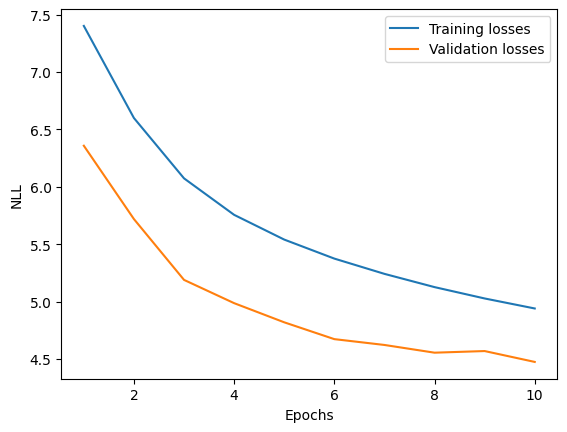

In [40]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses[0:10], label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

# Create handin

In [49]:
# TODO: Generate the handin to submit to autolab
!make runid=<'1681491014'> epoch=<10>

/bin/bash: -c: line 0: syntax error near unexpected token `10'
/bin/bash: -c: line 0: `make runid=<'1681491014'> epoch=<10>'
